Test 3: kerchunk with MUR 0.01 degree data, creating kerchunk references and accessing data all in the cloud

To install kerchunk, used
```
!pip install git+https://github.com/fsspec/kerchunk

```

In [ ]:
import os
import ujson

from kerchunk.hdf import SingleHdf5ToZarr
from kerchunk.combine import MultiZarrToZarr
import xarray as xr
import earthaccess
import coiled
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
earthaccess.login()
#shortname = "ECCO_L4_OCEAN_VEL_05DEG_MONTHLY_V4R4"
shortname = "ECCO_L4_SSH_05DEG_DAILY_V4R4"
granule_info = earthaccess.search_data(short_name = shortname)

Granules found: 9497


## Quick dataset inspection

In [11]:
fobjs = earthaccess.open(granule_info)

Opening 9497 granules, approx size: 9.15 GB
using endpoint: https://archive.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/9497 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/9497 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/9497 [00:00<?, ?it/s]

In [12]:
example_data = xr.open_dataset(fobjs[0], chunks={})
example_data

<xarray.Dataset> Size: 3MB
Dimensions:         (time: 1, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 8B 1992-01-01T18:00:00
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] 16B dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 1MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 1MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 1MB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-01-02T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Daily Mean 0.5 De...
    uuid:                         116970b6-404a-11eb-8721-0cc47a3f86f5

In [13]:
nbytes_singlefile = example_data.nbytes
print("Size of single file uncompressed", nbytes_singlefile/10**6, "MB")
print("Size of entire dataset uncompressed", nbytes_singlefile*len(granule_info)/10**9, "GB")

Size of single file uncompressed 3.123384 MB
Size of entire dataset uncompressed 29.662777848 GB


## Create reference files

### Single reference files

In [14]:
## Store reference JSONs in these directories:
dir_refs = './reference_jsons_'+shortname+'/'
dir_refs_indv = dir_refs+'individual/'
dir_refs_comb = dir_refs+'combined/'

In [15]:
!mkdir $dir_refs
!mkdir $dir_refs_indv
!mkdir $dir_refs_comb

In [16]:
def single_ref_earthaccess(fobj):
    """
    Inputs
    ------
    fobj: earthaccess.store.EarthAccessFile object
        Obtained from a call to earthaccess.open().
    """
    endpoint = fobj.full_name
    reference = SingleHdf5ToZarr(fobj, endpoint, inline_threshold=0).translate()
    return reference, endpoint # returns both the kerchunk reference and the path the file on podaac-ops-cumulus-protected

In [17]:
%%time

# Wrap `create_single_ref` into coiled function:
single_ref_earthaccess_par = coiled.function(
    region="us-west-2", spot_policy="on-demand", 
    vm_type="m6i.large", n_workers=50
    )(single_ref_earthaccess)

# Begin computations:
fobjs_process = fobjs[:]
results = single_ref_earthaccess_par.map(fobjs_process)

# Save results to JSONs as they become available:
for reference, endpoint in results:
    name_ref = dir_refs_indv + endpoint.split('/')[-1].replace('.nc', '.json')
    with open(name_ref, 'w') as outf:
        outf.write(ujson.dumps(reference))

single_ref_earthaccess_par.cluster.shutdown()

Output()

╭──────────────────────────────── Package Info ────────────────────────────────╮
│            ╷                                                                 │
│   Package  │ Note                                                            │
│ ╶──────────┼───────────────────────────────────────────────────────────────╴ │
│   kerchunk │ Wheel built from                                                │
│            │ /opt/coiled/env/.path-deps/kerchunk-0.2.5.post5-py3-none-any.   │
│            │ whl                                                             │
│            ╵                                                                 │
╰──────────────────────────────────────────────────────────────────────────────╯

Output()

CPU times: user 6.73 s, sys: 698 ms, total: 7.43 s
Wall time: 3min 36s


### Combined reference file

In [18]:
## Get AWS creds from first file-object in the list:
remote_options = {"anon": False, "key": fobjs[0].f.s3.key, "secret": fobjs[0].f.s3.secret, "token": fobjs[0].f.s3.token}

In [19]:
# Quick check of output:
ref_files_indv = [dir_refs_indv+f for f in os.listdir(dir_refs_indv) if f.endswith('.json')]
ref_files_indv.sort()
print(len(ref_files_indv))
ref_files_indv[:10]

9497


['./reference_jsons_ECCO_L4_SSH_05DEG_DAILY_V4R4/individual/SEA_SURFACE_HEIGHT_day_mean_1992-01-01_ECCO_V4r4_latlon_0p50deg.json',
 './reference_jsons_ECCO_L4_SSH_05DEG_DAILY_V4R4/individual/SEA_SURFACE_HEIGHT_day_mean_1992-01-02_ECCO_V4r4_latlon_0p50deg.json',
 './reference_jsons_ECCO_L4_SSH_05DEG_DAILY_V4R4/individual/SEA_SURFACE_HEIGHT_day_mean_1992-01-03_ECCO_V4r4_latlon_0p50deg.json',
 './reference_jsons_ECCO_L4_SSH_05DEG_DAILY_V4R4/individual/SEA_SURFACE_HEIGHT_day_mean_1992-01-04_ECCO_V4r4_latlon_0p50deg.json',
 './reference_jsons_ECCO_L4_SSH_05DEG_DAILY_V4R4/individual/SEA_SURFACE_HEIGHT_day_mean_1992-01-05_ECCO_V4r4_latlon_0p50deg.json',
 './reference_jsons_ECCO_L4_SSH_05DEG_DAILY_V4R4/individual/SEA_SURFACE_HEIGHT_day_mean_1992-01-06_ECCO_V4r4_latlon_0p50deg.json',
 './reference_jsons_ECCO_L4_SSH_05DEG_DAILY_V4R4/individual/SEA_SURFACE_HEIGHT_day_mean_1992-01-07_ECCO_V4r4_latlon_0p50deg.json',
 './reference_jsons_ECCO_L4_SSH_05DEG_DAILY_V4R4/individual/SEA_SURFACE_HEIGHT_day_

In [20]:
dims_nottime = list(example_data.dims.keys())
dims_nottime.remove('time')
dims_nottime

/tmp/ipykernel_64637/799786376.py:1: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  dims_nottime = list(example_data.dims.keys())


['latitude', 'longitude', 'nv']

In [21]:
%%time

## Combined reference file
mzz = MultiZarrToZarr(
    ref_files_indv,
    remote_protocol="s3",
    remote_options=remote_options,
    concat_dims=["time"], 
    identical_dims=dims_nottime
    )
ref_combined = mzz.translate()

 # Save reference info to JSON:
name_refcombined = dir_refs_comb + shortname + "_combined.json"
with open(name_refcombined, 'wb') as outf:
    outf.write(ujson.dumps(ref_combined).encode())

CPU times: user 1min 27s, sys: 6.13 s, total: 1min 33s
Wall time: 33min 30s


## Test combined reference file

In [22]:
%%time

name_refcombined = dir_refs_comb + shortname + "_combined.json"
data = xr.open_dataset(
    "reference://", engine="zarr", chunks={},
    backend_kwargs={
        "storage_options": {
            "fo": name_refcombined,
            "remote_protocol": "s3",
            "remote_options": remote_options
            },
        "consolidated": False
        }
)
data

CPU times: user 152 ms, sys: 12.3 ms, total: 164 ms
Wall time: 285 ms


<xarray.Dataset> Size: 30GB
Dimensions:         (time: 9497, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
    latitude_bnds   (time, latitude, nv) float32 27MB dask.array<chunksize=(1, 360, 2), meta=np.ndarray>
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    longitude_bnds  (time, longitude, nv) float32 55MB dask.array<chunksize=(1, 720, 2), meta=np.ndarray>
  * time            (time) datetime64[ns] 76kB 1992-01-01T18:00:00 ... 2017-1...
    time_bnds       (time, nv) datetime64[ns] 152kB dask.array<chunksize=(1, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 10GB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHIBC          (time, latitude, longitude) float32 10GB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
    SSHNOIBC        (time, latitude, longitude) float32 10GB dask.array<chunksize=(1, 360, 720), meta=np.ndarray>
Attributes: (12/57)
    Conventions:                  CF-1.8, ACDD-1.3
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-01-02T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-01-01T12:00:00
    title:                        ECCO Sea Surface Height - Daily Mean 0.5 De...
    uuid:                         116970b6-404a-11eb-8721-0cc47a3f86f5

In [23]:
%%time
#v1 = "EVEL"
v1 = "SSH"
data[v1].sel(time = data["time"][100]).mean().compute()

CPU times: user 25.7 ms, sys: 3.73 ms, total: 29.4 ms
Wall time: 141 ms


<xarray.DataArray 'SSH' ()> Size: 4B
array(-0.12598838, dtype=float32)
Coordinates:
    time     datetime64[ns] 8B 1992-04-10T12:00:00

### Control: open and compute with native netCDF files

In [24]:
%%time

data_control = xr.open_dataset(fobjs[100])
data_control

CPU times: user 52.3 ms, sys: 3.74 ms, total: 56.1 ms
Wall time: 127 ms


<xarray.Dataset> Size: 3MB
Dimensions:         (time: 1, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 8B 1992-04-10T12:00:00
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] 16B ...
    latitude_bnds   (latitude, nv) float32 3kB ...
    longitude_bnds  (longitude, nv) float32 6kB ...
Dimensions without coordinates: nv
Data variables:
    SSH             (time, latitude, longitude) float32 1MB ...
    SSHIBC          (time, latitude, longitude) float32 1MB ...
    SSHNOIBC        (time, latitude, longitude) float32 1MB ...
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on a regular lat-lon grid. ...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1D
    time_coverage_end:            1992-04-11T00:00:00
    time_coverage_resolution:     P1D
    time_coverage_start:          1992-04-10T00:00:00
    title:                        ECCO Sea Surface Height - Daily Mean 0.5 De...
    uuid:                         263998fe-404a-11eb-be73-0cc47a3f86f5

In [25]:
%%time
data_control[v1].mean()

CPU times: user 8.68 ms, sys: 38 μs, total: 8.72 ms
Wall time: 8.05 ms


<xarray.DataArray 'SSH' ()> Size: 4B
array(-0.12598838, dtype=float32)

In [99]:
%%time
data_mf_control = xr.open_mfdataset(fobjs[:100])
data_mf_control

CPU times: user 35.2 s, sys: 5.96 s, total: 41.2 s
Wall time: 2min 43s


<xarray.Dataset> Size: 16GB
Dimensions:         (time: 100, Z: 50, latitude: 360, longitude: 720, nv: 2)
Coordinates:
  * time            (time) datetime64[ns] 800B 1992-01-16T18:00:00 ... 2000-0...
  * Z               (Z) float32 200B -5.0 -15.0 -25.0 ... -5.461e+03 -5.906e+03
  * latitude        (latitude) float32 1kB -89.75 -89.25 -88.75 ... 89.25 89.75
  * longitude       (longitude) float32 3kB -179.8 -179.2 -178.8 ... 179.2 179.8
    time_bnds       (time, nv) datetime64[ns] 2kB dask.array<chunksize=(1, 2), meta=np.ndarray>
    latitude_bnds   (latitude, nv) float32 3kB dask.array<chunksize=(360, 2), meta=np.ndarray>
    longitude_bnds  (longitude, nv) float32 6kB dask.array<chunksize=(720, 2), meta=np.ndarray>
    Z_bnds          (Z, nv) float32 400B dask.array<chunksize=(50, 2), meta=np.ndarray>
Dimensions without coordinates: nv
Data variables:
    EVEL            (time, Z, latitude, longitude) float32 5GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    NVEL            (time, Z, latitude, longitude) float32 5GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
    WVEL            (time, Z, latitude, longitude) float32 5GB dask.array<chunksize=(1, 25, 180, 360), meta=np.ndarray>
Attributes: (12/62)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on a regular lat-lon gri...
    Conventions:                     CF-1.8, ACDD-1.3
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Velocity - Monthly Mean 0.5 D...
    uuid:                            9e491ab6-415a-11eb-b268-0cc47a3f7b49

In [103]:
%%time
mean_ts_1 = data_mf_control["NVEL"].isel(Z=0).mean(dim=["latitude", "longitude"]).compute()

CPU times: user 16.9 s, sys: 1.79 s, total: 18.6 s
Wall time: 57.6 s


In [116]:
%%time
mean_ts_2 = data["NVEL"].isel(Z=0, time=slice(0,100)).mean(dim=["latitude", "longitude"]).compute()

CPU times: user 12.3 s, sys: 890 ms, total: 13.2 s
Wall time: 7.48 s


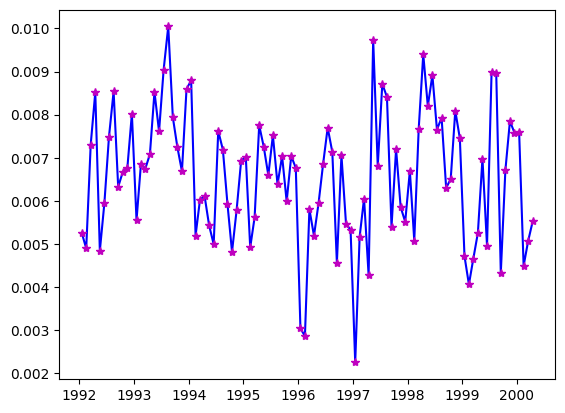

In [118]:
plt.plot(data_mf_control["time"], mean_ts_1, 'b-')
plt.plot(data_mf_control["time"], mean_ts_2, 'm*')